<h1 align="center">Semi Supervised Classification using AutoEncoders</h1>

## Introduction

By definition, machine learning can be defined as a complex process of learning the best possible and most relevant patterns, relationships, or associations from a dataset which can be used to predict the outcomes on unseen data. Broadly, their exists three different machine learning processes: 

**1. Supervised Learning** is a process of training a machine learning model on a labelled dataset ie. a dataset in which the target variable is known. In this technique, the model aims to find the relationships among the independent and dependent variable. Examples of supervised learning are classification, regression and forecasting. 

**2. Unsupervised Learning** is a process of training a machine learning model on a dataset in which target variable is not known. In this technique, the model aims to find the most relevant patterns in the data or the segments of data. Examples of unsupervised learning are clustering, segmentations, dimensionality reduction etc. 

**3. Semi-Supervised Learning** is combination of supervised and unsupervised learning processes in which the unlabelled data is used for training a model as well. In this approach, the properties of unspervised learning are used to learn the best possible representation of data and the properties of supervised learning are used to learn the relationships in the representations which are then used to make predictions. 

<p align="center">In this kernel, I have explained how to perform classification task using semi supervised learning approach. This approach makes use of autoencoders to learn the representation of the data then a simple linear classifier is trained to classify the dataset into respective classes.  
 
<br>
<h1 align="center">Fraud Detection using Semi Supervised Learning</h1>  

I am using the dataset of [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) by ULB machine learning group. Later, I am also applying the same technique on [Titanic](https://www.kaggle.com/c/titanic) dataset. A number of kagglers have shared different approaches such as dataset balancing, anomaly detection, boosting models, deep learning etc but this approach is different. 

### Contents 

1. Dataset Preparation  
2. Visualize Fraud Vs Non Fraud Transactions  
3. AutoEncoders : Latent Representation Extraction  
4. Obtain the Latent Representations  
5. Visualize Latent Representations : Fraud vs Non Fraud  
6. Simple Linear Classifier  
7. Applying the same technique on Titanic Dataset
 
## 1. Dataset Preparation

First, we will load all the required libraries and load the dataset using pandas dataframe. 
 



In [1]:
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn import preprocessing 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
np.random.seed(203)

data = pd.read_csv("../input/creditcardfraud/creditcard.csv")
data["Time"] = data["Time"].apply(lambda x : x / 3600 % 24)
data.head()

Using TensorFlow backend.


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The dataset consists of 28 anonymized variables, 1 "amount" variable, 1 "time" variable and 1 target variable - Class. Let's look at the distribution of target. 

In [2]:
vc = data['Class'].value_counts().to_frame().reset_index()
vc['percent'] = vc["Class"].apply(lambda x : round(100*float(x) / len(data), 2))
vc = vc.rename(columns = {"index" : "Target", "Class" : "Count"})
vc

,Target,Count,percent
0,0,284315,99.83
1,1,492,0.17


One of the biggest challenge of this problem is that the **target is highly imbalanced** as only **0.17 %** cases are fraud transactions. But the advantage of the representation learning approach is that it is still able to handle such imbalance nature of the problems. We will look how.  For our use-case let's take only about 1000 rows of non-fraud transactions. 

## Consider only 1000 rows of non fraud cases

In [3]:
non_fraud = data[data['Class'] == 0].sample(1000)
fraud = data[data['Class'] == 1]

df = non_fraud.append(fraud).sample(frac=1).reset_index(drop=True)
X = df.drop(['Class'], axis = 1).values
Y = df["Class"].values

## 2. Visualize Fraud and NonFraud Transactions 

Let's visualize the nature of fraud and non-fraud transactions using T-SNE. T-SNE (t-Distributed Stochastic Neighbor Embedding) is a dataset decomposition technique which reduced the dimentions of data and produces only top n components with maximum information.  

Every dot in the following represents a transaction. Non Fraud transactions are represented as Green while Fraud transactions are represented as Red. The two axis are the components extracted by tsne. 

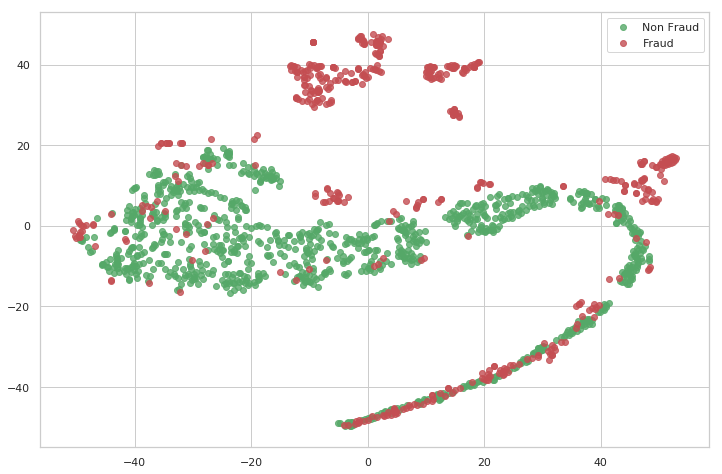

In [4]:
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Fraud')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fraud')

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
tsne_plot(X, Y, "original.png")

From the above graph we can observe that there are many non_fraud transactions which are very close to fraud transactions, thus are difficult to accurately classify from a model. 

## 3. AutoEncoders to the rescue 

<br>
**What are Autoencoders?** - Autoencoders are a special type of neural network architectures in which the output is same as the input. Autoencoders are trained in an unsupervised manner in order to learn the exteremely low level repersentations of the input data. These low level features are then deformed back to project the actual data. An autoencoder is a regression task where the network is asked to predict its input (in other words, model the identity function). These networks has a tight bottleneck of a few neurons in the middle, forcing them to create effective representations that compress the input into a low-dimensional code that can be used by the decoder to reproduce the original input. 

**More about Autoencoders** - If you want to gain more understanding about autoencoders, you can refer to the following kernel : https://www.kaggle.com/shivamb/how-autoencoders-work-intro-and-usecases

![](https://i.imgur.com/Rrmaise.png)

We will create an autoencoder model in which we only show the model non-fraud cases. The model will try to learn the best representation of non-fraud cases. The same model will be used to generate the representations of fraud cases and we expect them to be different from non-fraud ones. 

Create a network with one input layer and one output layer having identical dimentions ie. the shape of non-fraud cases. We will use keras package. 

In [5]:
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)

## decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)

Create the model architecture by compiling input layer and output layers. Also add the optimizer and loss function, I am using "adadelta" as the optimizer and "mse" as the loss function.

In [6]:
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

Before training, let's perform min max scaling. 

In [7]:
x = data.drop(["Class"], axis=1)
y = data["Class"].values

x_scale = preprocessing.MinMaxScaler().fit_transform(x.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

The beauty of this approach is that we do not need too many samples of data for learning the good representations. We will use **only 2000 rows** of non fraud cases to train the autoencoder. Additionally, We do not need to run this model for a large number of epochs. 

**Explanation:** The choice of small samples from the original dataset is based on the intuition that one class characteristics (non fraud) will differ from that of the other (fraud). To distinguish these characteristics we need to show the autoencoders only one class of data. This is because the autoencoder will try to learn only one class and automaticlly distinuish the other class. 

In [8]:
autoencoder.fit(x_norm[0:2000], x_norm[0:2000], 
                batch_size = 256, epochs = 10, 
                shuffle = True, validation_split = 0.20);

Train on 1600 samples, validate on 400 samples
Epoch 1/10
1600/1600 [==============================] - 0s 266us/step - loss: 0.7219 - val_loss: 0.4843
Epoch 2/10
1600/1600 [==============================] - 0s 18us/step - loss: 0.4610 - val_loss: 0.3263
Epoch 3/10
1600/1600 [==============================] - 0s 13us/step - loss: 0.3055 - val_loss: 0.2212
Epoch 4/10
1600/1600 [==============================] - 0s 18us/step - loss: 0.1996 - val_loss: 0.1239
Epoch 5/10
1600/1600 [==============================] - 0s 15us/step - loss: 0.1301 - val_loss: 0.1259
Epoch 6/10
1600/1600 [==============================] - 0s 15us/step - loss: 0.1313 - val_loss: 0.0889
Epoch 7/10
1600/1600 [==============================] - 0s 17us/step - loss: 0.0980 - val_loss: 0.0980
Epoch 8/10
1600/1600 [==============================] - 0s 15us/step - loss: 0.1137 - val_loss: 0.0793
Epoch 9/10
1600/1600 [==============================] - 0s 14us/step - loss: 0.0854 - val_loss: 0.0797
Epoch 10/10
1600/1600 [==

## 4. Obtain the Latent Representations 

Now, the model is trained. We are intereseted in obtaining **latent representation of the input** learned by the model. This can be accessed by the weights of the trained model. We will create another network containing sequential layers, and we will only add the trained weights till the third layer where latent representation exists. 

In [9]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

Generate the hidden representations of two classes : non-fraud and fraud by predicting the raw inputs using the above model.

In [10]:
norm_hid_rep = hidden_representation.predict(x_norm[:3000])
fraud_hid_rep = hidden_representation.predict(x_fraud)

## 5. Visualize the latent representations : Fraud Vs Non Fraud

Now we will create a training dataset using the latent representations obtained and let's visualize the nature of fraud vs non-fraud cases. 

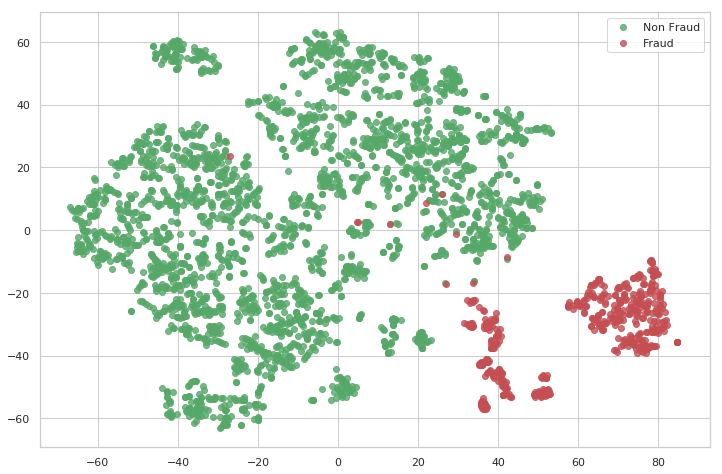

In [11]:
rep_x = np.append(norm_hid_rep, fraud_hid_rep, axis = 0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(fraud_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
tsne_plot(rep_x, rep_y, "latent_representation.png")

What a perfect graph, we can observe that now fraud and non-fraud transactions are pretty visibile and are linearly separable. Now we dont need any complex model to classify this, even the simpler models can be used to predict.  Here is the before and after view of Fraud and Non Fraud transactions.

In [12]:
from IPython.display import display, Image, HTML
display(HTML("""<table align="center">
<tr ><td><b>Actual Representation (Before) </b></td><td><b>Latent Representation (Actual)</b></td></tr>
<tr><td><img src='original.png'></td><td>
             <img src='latent_representation.png'></td></tr></table>"""))

Actual Representation (Before),Latent Representation (Actual)
,


Now, we can just train a simple linear classifier on the dataset. 

## 6. Simple Linear Classifier

In [13]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       754
         1.0       1.00      0.87      0.93       119

   micro avg       0.98      0.98      0.98       873
   macro avg       0.99      0.94      0.96       873
weighted avg       0.98      0.98      0.98       873


Accuracy Score:  0.9828178694158075


## 7. Applying to a different dataset : Titanic 

Let's Apply this approach to another dataset. I will use the popular titanic dataset for this purpose.

In [14]:
train = pd.read_csv("../input/titanic/train.csv")
test = pd.read_csv("../input/titanic/test.csv")

Performing Some Feature Engineering Used in this Competition. The following Feature Engineering Code is derived from this [kernel](https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python) 

Feature Engineering Credits : 
1. https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python
2. https://www.kaggle.com/sinakhorami/titanic/titanic-best-working-classifier

In [15]:
import re 
full_data = [train, test]

train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)

for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)    
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare']         = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare']         = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    dataset.loc[ dataset['Age'] <= 16, 'Age']        = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Next, define the autoencoder model

In [16]:
X = train.drop(["Survived"], axis=1)
y = train["Survived"]
y = y.values

## define the model
input_layer = Input(shape=(X.shape[1],))
encoded = Dense(100, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoded = Dense(50, activation='relu')(encoded)
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)
output_layer = Dense(X.shape[1], activation='relu')(decoded)

autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

Train the model

In [17]:
scaler = preprocessing.MinMaxScaler()
scaler.fit(X.values)
X_scale = scaler.transform(X.values)
test_x_scale = scaler.transform(test.values)

x_perished, x_survived = X_scale[y == 0], X_scale[y == 1]
autoencoder.fit(x_perished, x_perished, epochs = 20, shuffle = True, validation_split = 0.25)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Train on 411 samples, validate on 138 samples
Epoch 1/20
411/411 [==============================] - 0s 878us/step - loss: 0.2494 - val_loss: 0.2252
Epoch 2/20
411/411 [==============================] - 0s 61us/step - loss: 0.2084 - val_loss: 0.2094
Epoch 3/20
411/411 [==============================] - 0s 64us/step - loss: 0.1961 - val_loss: 0.1987
Epoch 4/20
411/411 [==============================] - 0s 60us/step - loss: 0.1874 - val_loss: 0.1919
Epoch 5/20
411/411 [==============================] - 0s 75us/step - loss: 0.1815 - val_loss: 0.1866
Epoch 6/20
411/411 [==============================] - 0s 63us/step - loss: 0.1620 - val_loss: 0.1254
Epoch 7/20
411/411 [==============================] - 0s 62us/step - loss: 0.1208 - val_loss: 0.1160
Epoch 8/20
411/411 [==============================] - 0s 59us/step - loss: 0.1141 - val_loss: 0.1123
Epoch 9/20
411/411 [==============================] - 0s 63us/step - loss: 0.1105 - val_loss: 0.1099
Epoch 10/20
411/411 [=======================

Obtain the Hidden Representation

In [18]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [19]:
perished_hid_rep = hidden_representation.predict(x_perished)
survived_hid_rep = hidden_representation.predict(x_survived)

rep_x = np.append(perished_hid_rep, survived_hid_rep, axis = 0)
y_n = np.zeros(perished_hid_rep.shape[0])
y_f = np.ones(survived_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

Train the classifier 

In [20]:
train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression().fit(train_x, train_y)
pred_y = clf.predict(val_x)

print (classification_report(val_y, pred_y))
print (accuracy_score(val_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.83      0.90      0.86       131
         1.0       0.84      0.74      0.79        92

   micro avg       0.83      0.83      0.83       223
   macro avg       0.84      0.82      0.83       223
weighted avg       0.83      0.83      0.83       223

0.8340807174887892


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [21]:
temp = pd.DataFrame(pd.read_csv("../input/titanic/test.csv")['PassengerId'])
test_rep_x = hidden_representation.predict(test_x_scale)
temp['Survived'] = [int(x) for x in clf.predict(test_rep_x)]
temp.to_csv("submission.csv", index = False)
temp.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


Thus we can see that approach gives a decent results. With more data one can definately expect improvements. 
Thanks for viewing. If you liked it please upvote.